In [ ]:
import requests
import os
import pandas as pd

tickers = ['ALOS3','ABEV3','ASAI3','AURE3','AXIA3','AXIA6','AXIA7',
'AZZA3','B3SA3','BBSE3','BBDC3','BBDC4','BRAP4','BBAS3','BRKM5','BRAV3',
'BPAC11','CXSE3','CEAB3','CMIG4','COGN3','CSMG3','CPLE3','CSAN3','CPFE3',
'CMIN3','CURY3','CYRE3','CYRE4','DIRR3','EMBJ3','ENGI11','ENEV3','EGIE3',
'EQTL3','FLRY3','GGBR4','GOAU4','HAVP3','HYPE3','IGIT11','IRBR3','ISAE4',
'ITSA4','ITUB4','KLBN11','RENT3','RENT4','LREN3','MGLU3','POMO4','MBRF3',
'BEEF3','MOTV3','MRVE3','MULT3','NATU3','PCAR3','PETR3','PETR4','RECV3',
'PRIO3','PSSA3','RADL3','RAIZ4','RDOR3','RAIL3','SBSP3','SANB11','CSNA3',
'SLCE3','SMFT3','SUZB3','TAEE11','VIVT3','TIMS3','TOTS3','UGPA3','USIM5',
'VALE3','VAMO3','VBBR3','VIVA3','WEGE3','YDUQ3']

token = os.getenv('TOKEN')


def get_data(ticker, token, range='5y',interval='1d'):
    
    url = f'https://brapi.dev/api/quote/{ticker}'
    params = {
        'range':range,
        'interval':interval,
        'token':token
    }
    headers= {'Autorization': f'Bearer {token}'}
    
    try:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            if 'results' in data and len(data['results']) > 0:
                data_res = data['results'][0]['historicalDataPrice']
                if not data_res:
                    return None

                df = pd.DataFrame(data_res)
                df['date'] = pd.to_datetime(df['date'], unit='s').dt.normalize()
                df.set_index('date', inplace=True)
                df = df[['adjustedClose']]
                df.rename(columns={'adjustedClose':'close'}, inplace=True)
                return df
        else:
            print(f'Erro: {response_bova.status_code}')
            return None

    except Exception as e:
        print(f'Erro excep {ticker}: {e}')
        return None

#dados benchmark
df_bova = get_data('BOVA11',token)

if df_bova is not None:
    df_bova['pct_change'] = df_bova['close'].pct_change()

#dados ações
results = []

if df_bova is not None:
    for ticker in tickers:
        df_stock = get_data(ticker, token)

        if df_stock is not None:
            common_dates = df_stock.index.intersection(df_bova.index)

            if len(common_dates) < 50:
                print('Dados insuficientes')
                continue
                
            df_stock = df_stock.loc[common_dates].copy()
            bova_slice = df_bova.loc[common_dates].copy()

            df_stock['rs'] = df_stock['close'] / bova_slice['close']

            df_stock['rs_ema21'] = df_stock['rs'].ewm(span=21, adjust=False).mean()
            df_stock['stock_ema20'] = df_stock['close'].ewm(span=20, adjust=False).mean()
            df_stock['stock_ema50'] = df_stock['close'].ewm(span=50, adjust=False).mean()

            cond_rs = df_stock['rs'] > df_stock['rs_ema21']
            cond_price = df_stock['close'] > df_stock['stock_ema50']
            cond_emas = df_stock['stock_ema20'] > df_stock['stock_ema50']

            df_stock['signal'] = cond_rs & cond_price & cond_emas

            df_stock['pct_change'] = df_stock['close'].pct_change()
            bova_slice['pct_change'] = bova_slice['close'].pct_change()

            retornos_filtrados_stock = df_stock.loc[df_stock['signal'],'pct_change']
            retornos_filtrados_bova = bova_slice.loc[df_stock['signal'],'pct_change']

            if len(retornos_filtrados_stock) > 0:
                retorno_total_stock = (1 + retornos_filtrados_stock).prod() - 1
                retorno_total_bova = (1 + retornos_filtrados_bova).prod() - 1
                dias_condicao_ativa = len(retornos_filtrados_stock)
                
                last_signal = df_stock['signal'].iloc[-1]
                last_rs_gt_ema = cond_rs.iloc[-1]
                last_price_gt_emas = cond_price.iloc[-1]
                
                results.append({
                    'Ticker': ticker,
                    'Days Active': dias_condicao_ativa,
                    'Strategy Return': retorno_total_stock,
                    'BOVA11 Return (Same Period)': retorno_total_bova,
                    'Outperformance': retorno_total_stock - retorno_total_bova,
                    'Active Today': last_signal,
                    'RS > EMA21': last_rs_gt_ema,
                    'Price > EMAs': last_price_gt_emas
                })
                print(f'OK. Dias ativos: {dias_condicao_ativa}')
            else:
                print('Sem sinais válidos.')
        else:  
            print('falha no download')
    
    df_results = pd.DataFrame(results)
     
    if not df_results.empty:
        df_results['Strategy Return %'] = df_results['Strategy Return'] * 100
        df_results['BOVA11 Return %'] = df_results['BOVA11 Return (Same Period)'] * 100
        df_results['Outperformance %'] = df_results['Outperformance'] * 100
        
        df_results = df_results.sort_values(by='Outperformance', ascending=False)
        
        df_results.to_csv('resultado_rs_ema.csv', index=False)
        print('Resultados salvos em "resultado_rs_ema.csv"')
        
        print('TOP 20 AÇÕES COM MELHOR PERFORMANCE')
        display(df_results[['Ticker', 'Days Active', 'Strategy Return %', 'BOVA11 Return %', 'Outperformance %']].head(20))
        
        print('AÇÕES COM SINAL ATIVO HOJE ')
        active_today = df_results[df_results['Active Today'] == True]
        display(active_today[['Ticker', 'Strategy Return %', 'Outperformance %']])
    else:
        print('Nenhum resultado gerado.')

OK. Dias ativos: 172
OK. Dias ativos: 316
OK. Dias ativos: 392
OK. Dias ativos: 209
OK. Dias ativos: 485
OK. Dias ativos: 529
Dados insuficientes
OK. Dias ativos: 41
OK. Dias ativos: 326
OK. Dias ativos: 521
OK. Dias ativos: 368
OK. Dias ativos: 372
OK. Dias ativos: 337
OK. Dias ativos: 564
OK. Dias ativos: 263
OK. Dias ativos: 316
OK. Dias ativos: 488
OK. Dias ativos: 445
OK. Dias ativos: 438
OK. Dias ativos: 469
OK. Dias ativos: 348
OK. Dias ativos: 566
OK. Dias ativos: 478
OK. Dias ativos: 183
OK. Dias ativos: 430
OK. Dias ativos: 355
OK. Dias ativos: 623
OK. Dias ativos: 446
Dados insuficientes
OK. Dias ativos: 571
OK. Dias ativos: 28
OK. Dias ativos: 370
OK. Dias ativos: 372
OK. Dias ativos: 305
OK. Dias ativos: 394
OK. Dias ativos: 284
OK. Dias ativos: 407
OK. Dias ativos: 405
Erro excep HAVP3: name 'response_bova' is not defined
falha no download
OK. Dias ativos: 352
Erro excep IGIT11: name 'response_bova' is not defined
falha no download
OK. Dias ativos: 175
OK. Dias ativos: 77

,Ticker,Days Active,Strategy Return %,BOVA11 Return %,Outperformance %
40,ITUB4,751,105138.533611,93.722227,105044.811384
21,CPLE3,478,8125.517214,-5.111497,8130.628710
17,CEAB3,438,7167.696001,43.669834,7124.026167
25,CURY3,623,4741.716423,88.104061,4653.612362
19,COGN3,348,3604.660349,102.651104,3502.009244
46,MBRF3,491,3315.048362,-20.086950,3335.135312
45,POMO4,544,3088.201855,36.113048,3052.088807
27,DIRR3,571,2391.651276,37.341440,2354.309836
53,PETR3,617,2207.663588,13.332220,2194.331367
54,PETR4,602,2002.401102,19.848417,1982.552684


AÇÕES COM SINAL ATIVO HOJE 


,Ticker,Strategy Return %,Outperformance %
40,ITUB4,105138.533611,105044.811384
19,COGN3,3604.660349,3502.009244
53,PETR3,2207.663588,2194.331367
54,PETR4,2002.401102,1982.552684
20,CSMG3,1986.608420,1953.246718
79,YDUQ3,1556.360406,1510.192356
5,AXIA6,1488.047299,1406.255791
56,PRIO3,1213.351871,1209.547993
12,BBAS3,935.193265,904.787633
47,BEEF3,905.721265,885.743789


Maior Outperformance:


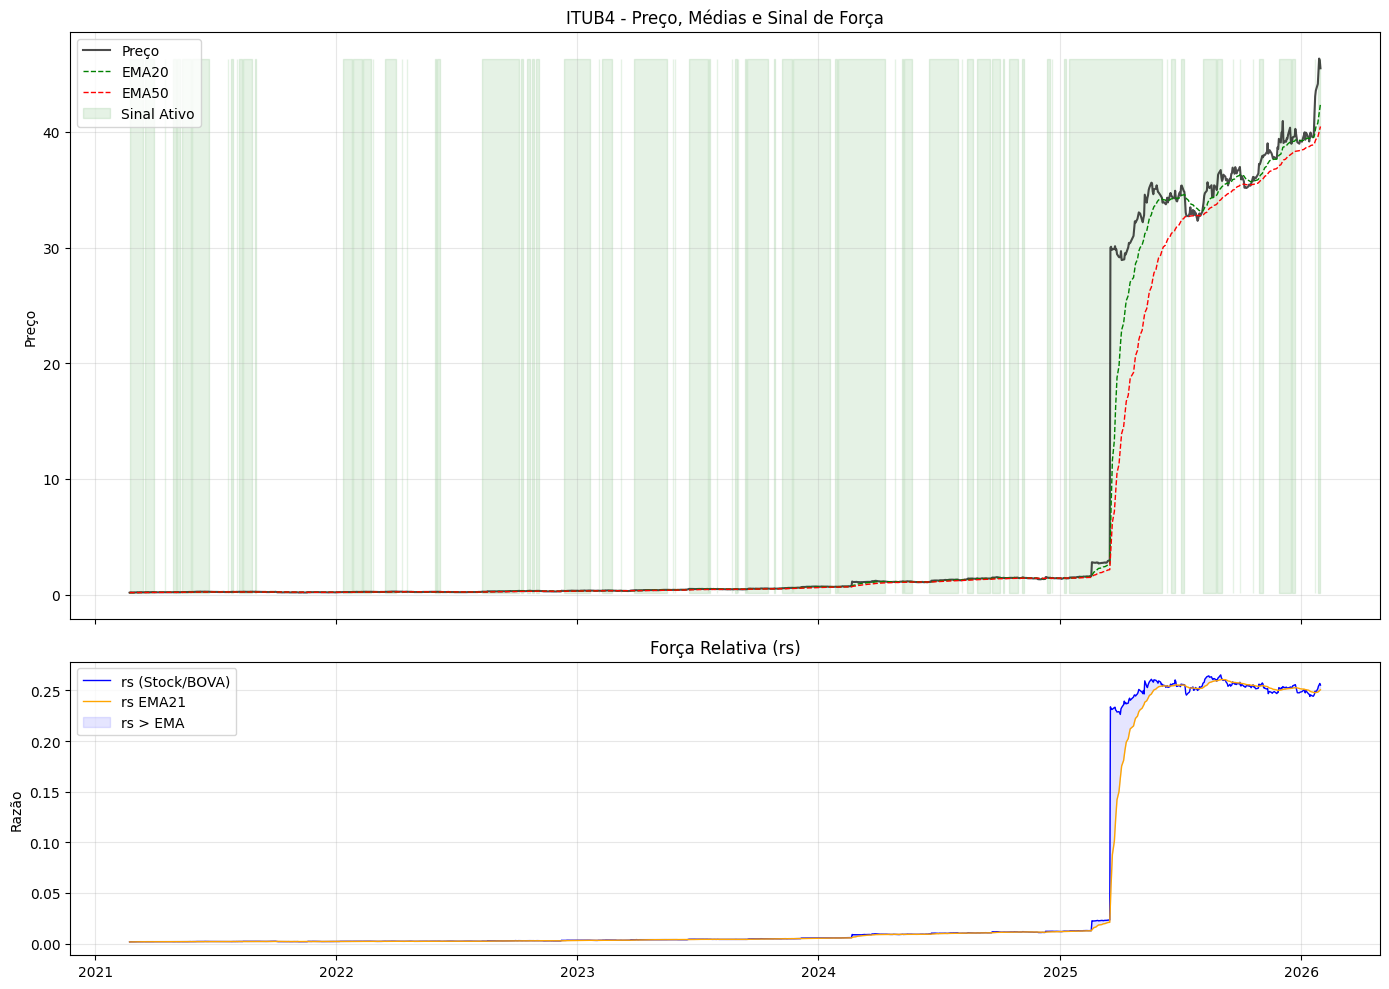

Ação Ativa Hoje (atrasado pela api):


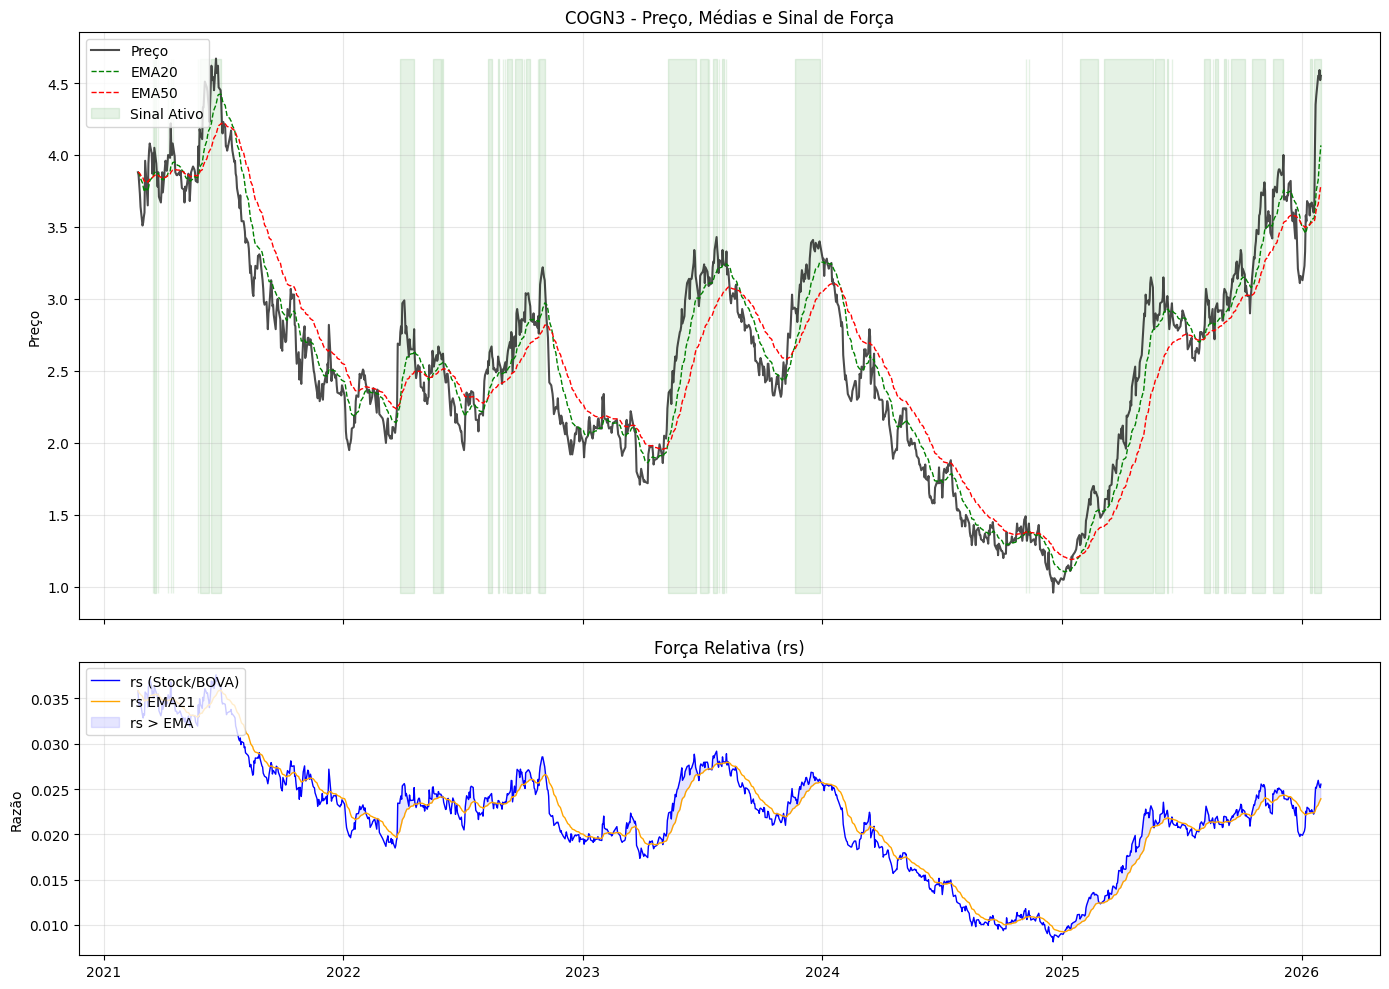

In [ ]:
import matplotlib.pyplot as plt

def plot_stock_strategy(ticker_symbol):
    
    df = get_data(ticker_symbol, token)
    if df is None: return

    common_dates = df.index.intersection(df_bova.index)
    df = df.loc[common_dates].copy()
    bova_slice = df_bova.loc[common_dates].copy()
    
    df['rs'] = df['close'] / bova_slice['close']
    df['rs_ema21'] = df['rs'].ewm(span=21, adjust=False).mean()
    df['stock_ema20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['stock_ema50'] = df['close'].ewm(span=50, adjust=False).mean()
    
    cond_rs = df['rs'] > df['rs_ema21']
    cond_price = (df['close'] > df['stock_ema20']) & (df['close'] > df['stock_ema50'])
    cond_align = df['stock_ema20'] > df['stock_ema50']
    df['Signal'] = cond_rs & cond_price & cond_align
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    ax1.plot(df.index, df['close'], label='Preço', color='black', alpha=0.7)
    ax1.plot(df.index, df['stock_ema20'], label='EMA20', color='green', linestyle='--', linewidth=1)
    ax1.plot(df.index, df['stock_ema50'], label='EMA50', color='red', linestyle='--', linewidth=1)
    
    y_min, y_max = df['close'].min(), df['close'].max()
    ax1.fill_between(df.index, y_min, y_max, where=df['Signal'], color='green', alpha=0.1, label='Sinal Ativo')
    
    ax1.set_title(f'{ticker_symbol} - Preço, Médias e Sinal de Força')
    ax1.set_ylabel('Preço')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df.index, df['rs'], label='rs (Stock/BOVA)', color='blue', linewidth=1)
    ax2.plot(df.index, df['rs_ema21'], label='rs EMA21', color='orange', linewidth=1)
    
    ax2.fill_between(df.index, df['rs'], df['rs_ema21'], where=(df['rs'] > df['rs_ema21']), color='blue', alpha=0.1, label='rs > EMA')
    
    ax2.set_title('Força Relativa (rs)')
    ax2.set_ylabel('Razão')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if 'df_results' in locals() and not df_results.empty:
    print('Maior Outperformance:')
    champion = df_results.iloc[0]['Ticker']
    plot_stock_strategy(champion)
    
    active_now = df_results[(df_results['Active Today'] == True) & (df_results['Ticker'] != champion)]
    if not active_now.empty:
        print('Ação Ativa Hoje (atrasado pela api):')
        plot_stock_strategy(active_now.iloc[0]['Ticker'])